Compiling model...
'compile' took 0.000370 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.50e+00, 0.00e+00, 4.64e-04, 5.17e+00]    [1.52e+00, 0.00e+00, 4.64e-04, 5.17e+00]    []  
0 [2.00e+00]
1000      [4.80e-01, 2.38e-01, 1.18e-03, 1.42e+00]    [4.76e-01, 2.38e-01, 1.18e-03, 1.42e+00]    []  
1000 [2.42e+00]
2000      [4.64e-01, 1.86e-01, 7.29e-04, 1.24e+00]    [4.61e-01, 1.86e-01, 7.29e-04, 1.24e+00]    []  
2000 [3.27e+00]
3000      [4.16e-01, 1.64e-01, 1.65e-04, 1.10e+00]    [4.11e-01, 1.64e-01, 1.65e-04, 1.10e+00]    []  
3000 [4.18e+00]
4000      [3.69e-01, 1.45e-01, 1.23e-04, 9.78e-01]    [3.64e-01, 1.45e-01, 1.23e-04, 9.78e-01]    []  
4000 [5.11e+00]
5000      [3.30e-01, 1.26e-01, 1.39e-03, 8.53e-01]    [3.25e-01, 1.26e-01, 1.39e-03, 8.53e-01]    []  
5000 [6.04e+00]
6000      [2.80e-01, 1.10e-01, 4.33e-05, 7.51e-01]    [2.75e-01, 1.10e-01, 4.33e-05, 7.51e-01]    []  
6000 [6.97e

Text(0.6, -0.8, 'C1 PINN:18.581\nC1 real:20')

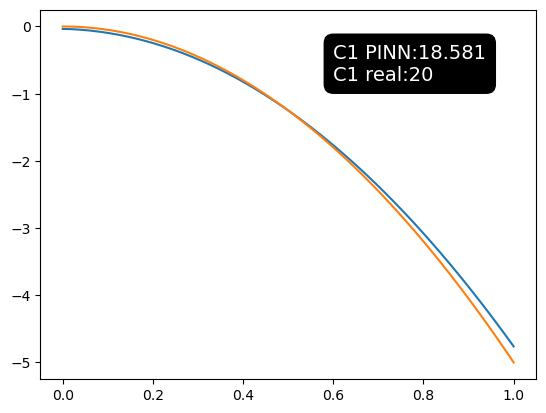

In [88]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import matplotlib.pyplot as plt
plt.style.use('default')
import numpy as np
C1 = dde.Variable(1.0)

geom = dde.geometry.Interval(0, 1)

def gen_traindata(num):
    # xvals = np.linspace(0, 1, num).reshape(num, 1)
    xvals = np.linspace(0, 1, num).reshape(-1, 1)
    uvals = sol(xvals)
    # print(uvals)
    return xvals, uvals

def pde(x, y):
    dA_dr = dde.grad.jacobian(y, x, i=0, j=0)
    dr_dA_dr = dde.grad.jacobian(dA_dr * x, x, i=0, j=0)
    # C1 = 20
    return dr_dA_dr + C1 * x

class exact_solution():
    def __init__(self, A0=71, muJz=20):
        self.A0 = A0
        self.A0 = 0
        self.muJz = muJz
    def __call__(self, r):
        return self.A0 - 1/4 * self.muJz * r**2
        # return self.A0 - 1 * self.muJz * r**2

sol = exact_solution(A0=71, muJz=20)
    
def boundary_l(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0)

def boundary_r(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1)

bc1 = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_l)
bc2 = dde.icbc.NeumannBC(geom, lambda x: 0, boundary_l)
# bc2 = dde.icbc.DirichletBC(geom, sol, lambda _, on_boundary: on_boundary, component=66)

ob_x, ob_u = gen_traindata(100)
observe_u = dde.icbc.PointSetBC(ob_x, ob_u)

data = dde.data.PDE(
    geom,
    pde,
    [bc1, bc2, observe_u],
    num_domain=200,
    num_boundary=1,
    anchors=ob_x,
    num_test=1000,
)

net = dde.nn.FNN([1] + [40] * 3 + [1], "tanh", "Glorot uniform")
# net = dde.nn.PFNN([1, [20, 20], [20, 20], [20, 20], 1], "tanh", "Glorot uniform")
model = dde.Model(data, net)
variable = dde.callbacks.VariableValue(C1, period=1000)
model = dde.Model(data, net)
model.compile("adam", lr=0.001, external_trainable_variables=[C1])
losshistory, train_state = model.train(iterations=20000, callbacks=[variable])
# model.compile("adam", lr=0.001)
# losshistory, train_state = model.train(iterations=5000)

x = geom.uniform_points(50)
yhat = model.predict(x)
print("C1:", C1)
plt.plot(x, yhat, label="y_hat")
plt.plot(ob_x, ob_u, label="y_true")
x_position = 0.6
y_position = -.8
fontsize = 14
plt.text(x_position, y_position, "C1 PINN:{:.3f}\nC1 real:{}".format(float(C1), 20),  fontsize=fontsize, color='white', bbox=dict(facecolor='black', edgecolor='none', boxstyle='round,pad=0.5'))
# plt.text(x_position, y_position-0.2, "C1 real:{:.3f}".format(float(20)),  fontsize=fontsize, color='white', bbox=dict(facecolor='black', edgecolor='none', boxstyle='round,pad=0.5'))
# ob_u

Compiling model...
'compile' took 0.000452 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.10e-01, 4.94e+05, nan]         [3.03e-01, 4.94e+05, nan]         []  

Best model at step 0:
  train loss: inf
  test loss: inf
  test metric: 

'train' took 0.011708 s

l2 relative error for u: 0.9940762
l2 relative error for q: 0.99865454


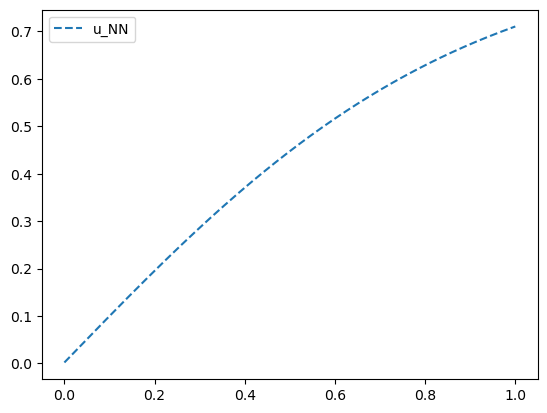

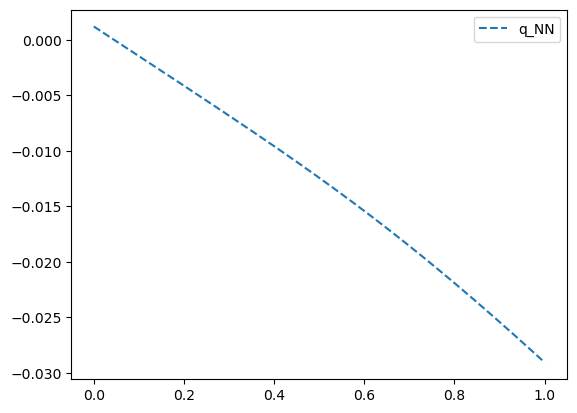

In [109]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np

exact_sol = exact_solution()
def gen_traindata(num):
    # generate num equally-spaced points from -1 to 1
    xvals = np.linspace(0, 1, num).reshape(num, 1)
    uvals = exact_sol(xvals)
    return xvals, uvals


def pde(x, y):
    u, q = y[:, 0:1], y[:, 1:2]
    du_dx = dde.grad.jacobian(y, x, i=0, j=0)
    dx_du_dx = dde.grad.jacobian(du_dx * x, x, i=0, j=0)
    # du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    return -dx_du_dx + q


def sol(x):
    # solution is u(x) = sin(pi*x), q(x) = -pi^2 * sin(pi*x)
    return np.sin(np.pi * x)


geom = dde.geometry.Interval(0, 1)

bc = dde.icbc.DirichletBC(geom, sol, lambda _, on_boundary: on_boundary, component=0)
ob_x, ob_u = gen_traindata(100)

def boundary_l(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1)


# 定义左边界条件
# 假设左边界上的解是已知的，这里我们以 u_left 表示
bc_left = dde.DirichletBC(geom, lambda x: 71, boundary_l)


# observe_u = dde.icbc.PointSetBC(ob_x, ob_u, component=71)

data = dde.data.PDE(
    geom,
    pde,
    [bc_left, observe_u],
    num_domain=200,
    num_boundary=1,
    anchors=ob_x,
    num_test=1000,
)

net = dde.nn.PFNN([1, [20, 20], [20, 20], [20, 20], 2], "tanh", "Glorot uniform")

model = dde.Model(data, net)
model.compile("adam", lr=0.0001, loss_weights=[1, 100, 1000])
losshistory, train_state = model.train(iterations=20000)
# dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# view results
x = geom.uniform_points(500)
yhat = model.predict(x)
uhat, qhat = yhat[:, 0:1], yhat[:, 1:2]

# utrue = np.sin(np.pi * x)
utrue = exact_sol(x)
print("l2 relative error for u: " + str(dde.metrics.l2_relative_error(utrue, uhat)))
plt.figure()
# plt.plot(x, utrue, "-", label="u_true")
plt.plot(x, uhat, "--", label="u_NN")
plt.legend()

# qtrue = -np.pi ** 2 * np.sin(np.pi * x)
qtrue = -20 * x
print("l2 relative error for q: " + str(dde.metrics.l2_relative_error(qtrue, qhat)))
plt.figure()
# plt.plot(x, qtrue, "-", label="q_true")
plt.plot(x, qhat, "--", label="q_NN")
plt.legend()

plt.show()

Compiling model...
'compile' took 0.000378 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [5.02e+00, 0.00e+00, 4.53e-01, 1.05e-01, 1.26e-01]    [5.22e+00, 0.00e+00, 4.53e-01, 1.05e-01, 1.26e-01]    [6.28e+00]    
1000      [1.95e-03, 5.85e-07, 1.50e-05, 3.44e-04, 1.15e-05]    [1.72e-03, 5.85e-07, 1.50e-05, 3.44e-04, 1.15e-05]    [6.16e-01]    
2000      [8.63e-04, 2.93e-08, 6.30e-07, 2.39e-05, 1.46e-06]    [7.52e-04, 2.93e-08, 6.30e-07, 2.39e-05, 1.46e-06]    [5.29e-01]    
3000      [3.98e-04, 5.27e-09, 1.27e-07, 3.57e-06, 7.00e-07]    [3.47e-04, 5.27e-09, 1.27e-07, 3.57e-06, 7.00e-07]    [5.12e-01]    
4000      [3.58e-05, 1.35e-10, 1.21e-08, 1.42e-07, 2.33e-07]    [3.03e-05, 1.35e-10, 1.21e-08, 1.42e-07, 2.33e-07]    [5.02e-01]    
5000      [1.69e-05, 5.36e-09, 1.18e-08, 2.44e-08, 8.92e-08]    [1.39e-05, 5.36e-09, 1.18e-08, 2.44e-08, 8.92e-08]    [5.02e-01]    

Bes

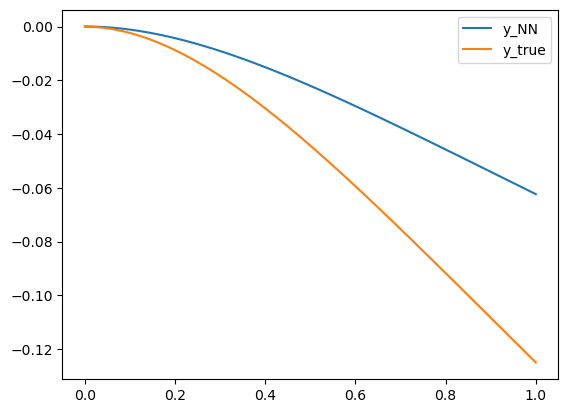

In [38]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("default")
dde.config.set_random_seed(9807)

def ddy(x, y):
    return dde.grad.hessian(y, x)


def dddy(x, y):
    return dde.grad.jacobian(ddy(x, y), x)

C1 = dde.Variable(0.5)
def pde(x, y):
    dy_xx = ddy(x, y)
    dy_xxxx = dde.grad.hessian(dy_xx, x)
    return dy_xxxx + C1


def boundary_l(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0)


def boundary_r(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1)


def func(x):
    return -(x**4) / 24 + x**3 / 6 - x**2 / 4


geom = dde.geometry.Interval(0, 1)

bc1 = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_l)
bc2 = dde.icbc.NeumannBC(geom, lambda x: 0, boundary_l)
bc3 = dde.icbc.OperatorBC(geom, lambda x, y, _: ddy(x, y), boundary_r)
bc4 = dde.icbc.OperatorBC(geom, lambda x, y, _: dddy(x, y), boundary_r)

data = dde.data.PDE(
    geom,
    pde,
    [bc1, bc2, bc3, bc4],
    num_domain=40,
    num_boundary=2,
    solution=func,
    num_test=1000,
)

layer_size = [1] + [20] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
variable = dde.callbacks.VariableValue([C1], period=600, filename="variables.dat")
losshistory, train_state = model.train(iterations=5000, callbacks=[variable])
x = geom.uniform_points(50)
yhat = model.predict(x)
y_true = func(x)
# print("C1:", C1)
plt.plot(x, yhat, label="y_NN")
plt.plot(x, y_true, label="y_true")
plt.legend()
print("C1:", C1)
# dde.saveplot(losshistory, train_state, issave=True, isplot=True)

{'w_pde': 0.1, 'w_bc': 2, 'w_data': 30, 'w_D1': 1000, 'w_D2': 1000, 'w_N': 1000}
net.0.weight
net.0.bias
net.2.weight
net.2.bias
net.4.weight
net.4.bias
net.6.weight
net.6.bias
net.8.weight
net.8.bias
Epoch 0, Loss: 3381.5732421875, muJz: tensor([-0.0133], grad_fn=<SelectBackward0>)
Epoch 100, Loss: 0.7072992920875549, muJz: tensor([2.9927], grad_fn=<SelectBackward0>)
Epoch 200, Loss: 0.5474627614021301, muJz: tensor([3.0926], grad_fn=<SelectBackward0>)
Epoch 300, Loss: 0.4374254047870636, muJz: tensor([2.6979], grad_fn=<SelectBackward0>)
Epoch 400, Loss: 0.4415142238140106, muJz: tensor([2.7511], grad_fn=<SelectBackward0>)
Epoch 500, Loss: 0.458728551864624, muJz: tensor([3.0202], grad_fn=<SelectBackward0>)
Epoch 600, Loss: 0.4460197389125824, muJz: tensor([3.1124], grad_fn=<SelectBackward0>)
Epoch 700, Loss: 0.3678337037563324, muJz: tensor([3.0202], grad_fn=<SelectBackward0>)
Epoch 800, Loss: 0.35604235529899597, muJz: tensor([2.8939], grad_fn=<SelectBackward0>)
Epoch 900, Loss: 0.3

NameError: name '__file__' is not defined

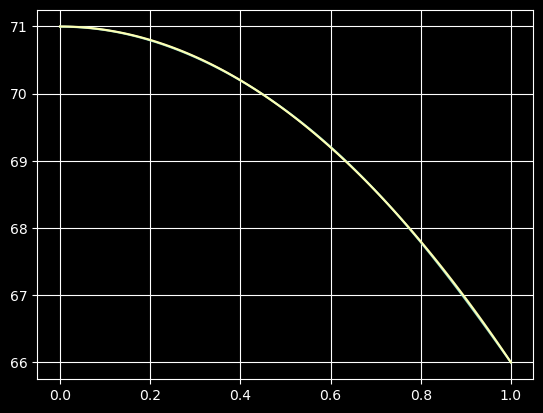

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import copy
import time
import matplotlib.pyplot as plt
import os

def normalize(value, min_value, max_value):
    """将值归一化到 [0, 1] 范围内。"""
    return (value - min_value) / (max_value - min_value)

def denormalize(value, min_value, max_value):
    """将归一化的值反归一化到原始范围。"""
    return value * (max_value - min_value) + min_value

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.neuron = 100
        neuron  = self.neuron
        self.net = nn.Sequential(
            nn.Linear(1, neuron),  
            nn.Tanh(),         
            nn.Linear(neuron, neuron),
            nn.Tanh(),         
            nn.Linear(neuron, neuron),
            nn.Tanh(),         
            nn.Linear(neuron, neuron),
            nn.Tanh(),        
            nn.Linear(neuron, 1), 
        )
        
    def forward(self, r):
        return self.net(r)

class muJz_net(nn.Module):
    def __init__(self):
        super(muJz_net, self).__init__()
        self.neuron = 100
        neuron  = self.neuron
        # 定义muJz网络
        self.muJz_net = nn.Sequential(
            nn.Linear(neuron, neuron),  
            nn.ReLU(),             
            nn.Linear(neuron, neuron), 
            nn.ReLU(),             
            nn.Linear(neuron, 1),  
        )
        
    def forward(self, r):
        muJz_input = torch.ones(1, self.neuron)  
        muJz_output = self.muJz_net(muJz_input)
        # 返回主网络输出和muJz网络输出
        model.muJz = muJz_output
        return muJz_output

lossfunc = nn.MSELoss(reduction='sum')

def compute_loss(model, muJz_model, r, muJz=20, A0_ori=72, A1_ori=67, ws = {"w_pde":1, "w_data":1, "w_bc":1, "w_D1":1, "w_D2":1, "w_N":1}):
    r.requires_grad = True  # 允许对 r 求导
    w_pde = ws["w_pde"]
    w_data = ws["w_data"]
    w_bc = ws["w_bc"]
    w_D1 = ws["w_D1"]
    w_D2 = ws["w_D2"]
    w_N = ws["w_N"]

    
    # 归一化 A0 和 A1
    # 假设 A 的最小值和最大值分别为 A_min 和 A_max
    A_min = min(A0_ori, A1_ori)  # 获取 A0_ori 和 A1_ori 中的最小值
    A_max = max(A0_ori, A1_ori)  # 获取 A0_ori 和 A1_ori 中的最大值


    # 归一化 A0_ori 和 A1_ori
    A0 = normalize(A0_ori, A_min, A_max)
    A1 = normalize(A1_ori, A_min, A_max)

    # 网络预测 A_z
    A_z = model(r)
    # 对 A_z 关于 r 求一阶导数
    dA_z_dr = torch.autograd.grad(A_z, r, torch.ones_like(A_z), retain_graph=True, create_graph=True)[0]
    
    left_pde = torch.autograd.grad(r * dA_z_dr, r, torch.ones_like(dA_z_dr),retain_graph=True, create_graph=True)[0] 
    
    model_muJz = muJz_model(r)

    pde_loss = torch.nn.functional.mse_loss(left_pde, -r*model_muJz)
    # print(model.muJz.requires_grad)
    # print(model_muJz[0][0])
    # exit()
 # 
    # 边界条件损失
    r_0 = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True)
    A_0_pred = model(r_0)
    A_1_pred = model(torch.tensor([[1.0]], dtype=torch.float32))
    # Convert A0 and A1 to tensors if they are not already
    A0_tensor = torch.tensor([A0], dtype=torch.float32)  # Make sure A0 is a tensor
    A1_tensor = torch.tensor([A1], dtype=torch.float32)  # Make sure A1 is a tensor

    # Ensure A0_tensor and A1_tensor have the same shape as A_0_pred and A_1_pred, respectively
    # This might involve unsqueezing if A_0_pred and A_1_pred are more than 1D
    A0_tensor = A0_tensor.expand_as(A_0_pred)
    A1_tensor = A1_tensor.expand_as(A_1_pred)
    # print(A0_tensor, A1_tensor)
    # print(A_0_pred, A_1_pred)
    # exit()

    # Now use these tensors in your mse_loss calculations
    Dirichlet_BC_1 = lossfunc(A_0_pred, A0_tensor)
    Dirichlet_BC_2 = lossfunc(A_1_pred, A1_tensor)


    # 计算诺伊曼边界条件的损失（这里假设是导数为 0）
    Neumann_BC_grad = torch.autograd.grad(outputs=A_0_pred, inputs=r_0, grad_outputs=torch.ones_like(A_0_pred),retain_graph=True, create_graph=True)[0]
    # 假设期望的导数值为 0，创建一个与 Neumann_BC_grad 形状相同且所有值都为 0 的张量
    expected_grad = torch.zeros_like(Neumann_BC_grad)
    Neumann_BC = lossfunc(Neumann_BC_grad, expected_grad)

    # 注意：您可能需要调整损失项之间的权重
    boundary_loss = w_D1 * Dirichlet_BC_1 + w_D2* Dirichlet_BC_2 + w_N*Neumann_BC
    # print("Dirichlet_BC_1:", Dirichlet_BC_1, "Dirichlet_BC_2:", Dirichlet_BC_2, "Neumann_BC:", Neumann_BC)
    # exit()

    real_solution = exact_solution(r, A0_ori, muJz)
    real_solution = normalize(real_solution, min_value=A_min, max_value=A_max)
    # print(real_solution)
    # print("A_z", A_z)

    real_loss = lossfunc(A_z, real_solution)
    
    loss = w_pde * pde_loss + w_data * real_loss + w_bc*boundary_loss

    # print("pde_loss:", pde_loss, "real_loss:", real_loss, "boundary_loss:", boundary_loss)
    # exit()

    # loss = real_loss
    
    # print(loss)
    # exit()
    return loss

def train(model, muJz_model, muJz = 20, A0 = 71, A1 = 66,ws={"w_pde":1, "w_data":1, "w_bc":1, "w_D1":1, "w_D2":1, "w_N":1}, epochs=5000, lr=0.001, verbose = False):
    min_loss = float('inf')
    # for name, param in model.named_parameters():
    #     print(name)

    optimizer_PINN = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer_muJz = torch.optim.Adam(muJz_model.parameters(), lr=lr*10)
    muJz_lst = []
    for epoch in range(epochs):
        optimizer_PINN.zero_grad()
        optimizer_muJz.zero_grad()
        
        r_train = torch.rand((50, 1), dtype=torch.float32)

        loss = compute_loss(model, model_muJz, r_train, muJz=muJz, A0_ori=A0, A1_ori=A1, ws = ws)
        
        # 反向传播和优化
        loss.backward()
        optimizer_PINN.step()
        optimizer_muJz.step()
        muJz_lst.append(model.muJz)
        if epoch % 100 == 0 and verbose:
            print(f'Epoch {epoch}, Loss: {loss.item()}, muJz: {model.muJz[0]}')

def cal_error(A_z_pred, A_z_exact):
    return np.mean(np.abs(np.array(A_z_pred) - np.array(A_z_exact))) * 100
# 计算解析解
def exact_solution(r, A0=71, muJz=20):
    return A0 - 1/4 * muJz * r**2

if __name__ == "__main__":
    # 设置随机种子
    torch.manual_seed(9807)
    # 初始化模型并开始训练
    verbose = True
    muJz = 20
    epoch = 5000
    A0 = 71
    A1 = 66
    ws = {"w_pde": .1, "w_bc": 20, "w_data": 30, "w_D1": 100, "w_D2": 1000, "w_N": 1000}
    # ws = {"w_pde": 0, "w_bc": 0, "w_data": 30, "w_D1": 100, "w_D2": 1000, "w_N": 1000}
    ws = {"w_pde": .1, "w_bc": 2, "w_data": 30, "w_D1": 1000, "w_D2": 1000, "w_N": 1000}
    print(ws)
    model = PINN()
    model_muJz = muJz_net()
    start_time = time.time()
    train(model, model_muJz, epochs=epoch,  muJz=muJz, A0=A0, A1=A1, ws=ws, verbose=verbose)
    duration = time.time() - start_time
    
    print("Duration: {:.2f}s".format(duration))

    # 生成测试点
    r_test = torch.linspace(0, 1, 100).view(-1, 1)
    # 计算 PINN 的解
    A_min = min(A0, A1)  # 获取 A0_ori 和 A1_ori 中的最小值
    A_max = max(A0, A1)  # 获取 A0_ori 和 A1_ori 中的最大值

    A_z_pinn_pred, muJz_pinn_pred= model(r_test).detach().numpy(), model_muJz(r_test).detach().numpy()
    A_z_pinn = denormalize(A_z_pinn_pred, min_value=A_min, max_value=A_max)# denormlize the A_z_pinn_pred


    A_z_exact = exact_solution(r_test.numpy())
    muJz_error = cal_error(muJz_pinn_pred, 20)
    print("muJz:", muJz_pinn_pred)
    print("muJz Error: {:.2f}%".format(muJz_error))
    A_z_error = cal_error(A_z_exact=A_z_exact, A_z_pred=A_z_pinn)
    print("Az Error: {:.2f}%".format(A_z_error))
    plt.figure()
    plt.plot(r_test, A_z_pinn, label="PINN")
    plt.plot(r_test, A_z_exact, label="PINN")
    plt.grid(True)
    # 获取当前脚本文件的目录
    # current_dir = os.path.dirname(os.path.abspath(__file__))

    # # 构建完整的文件路径
    # file_path = os.path.join(current_dir, "inverse_Solution_w_pde{}.pdf".format(ws["w_pde"]))

    # # 保存文件
    # plt.savefig(file_path)
    plt.show()



In [35]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import numpy as np
# Backend tensorflow.compat.v1 or tensorflow
# from deepxde.backend import tf
# Backend pytorch
import torch
# Backend paddle
# import paddle


C = dde.Variable(15.0)


def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    # Backend tensorflow.compat.v1 or tensorflow
    # return (
    #     dy_t
    #     - C * dy_xx
    #     + tf.exp(-x[:, 1:])
    #     * (tf.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * tf.sin(np.pi * x[:, 0:1]))
    # )
    # Backend pytorch
    return (
        dy_t
        - C * dy_xx
        + torch.exp(-x[:, 1:])
        * (torch.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * x[:, 0:1]))
    )
    # Backend paddle
    # return (
    #     dy_t
    #     - C * dy_xx
    #     + paddle.exp(-x[:, 1:])
    #     * (paddle.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * paddle.sin(np.pi * x[:, 0:1]))
    # )


def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])


geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)

observe_x = np.vstack((np.linspace(-1, 1, num=10), np.full((10), 1))).T
observe_y = dde.icbc.PointSetBC(observe_x, func(observe_x), component=0)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic, observe_y],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    anchors=observe_x,
    solution=func,
    num_test=10000,
)

layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

model.compile(
    "adam", lr=0.001, metrics=["l2 relative error"], external_trainable_variables=C
)
variable = dde.callbacks.VariableValue(C, period=1000)
losshistory, train_state = model.train(iterations=50000, callbacks=[variable])

# dde.saveplot(losshistory, train_state, issave=True, isplot=True)
print("C:", C)

Compiling model...
'compile' took 0.001235 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [9.29e+00, 2.53e-01, 2.51e-01, 6.48e-02]    [8.26e+00, 2.53e-01, 2.51e-01, 6.48e-02]    [6.60e-01]    
0 [1.50e+01]
1000      [5.84e-03, 7.25e-02, 2.27e-01, 4.40e-02]    [3.16e-03, 7.25e-02, 2.27e-01, 4.40e-02]    [7.14e-01]    
1000 [1.50e+01]
2000      [3.89e-03, 6.01e-02, 1.60e-01, 4.84e-02]    [4.19e-03, 6.01e-02, 1.60e-01, 4.84e-02]    [7.66e-01]    
2000 [1.48e+01]
3000      [4.24e-03, 3.04e-02, 1.22e-01, 3.60e-02]    [8.63e-03, 3.04e-02, 1.22e-01, 3.60e-02]    [8.65e-01]    
3000 [1.47e+01]
4000      [2.38e-03, 2.24e-02, 1.07e-01, 3.42e-02]    [3.61e-02, 2.24e-02, 1.07e-01, 3.42e-02]    [9.08e-01]    
4000 [1.46e+01]
5000      [1.91e-03, 1.64e-02, 9.74e-02, 3.48e-02]    [1.70e-01, 1.64e-02, 9.74e-02, 3.48e-02]    [9.14e-01]    
5000 [1.45e+01]
6000      [1.48e-02, 1.25e-02, 9.00e-02, 3.57e-02] 